In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")

In [28]:
df = pd.read_csv("../../data/frames_errors.csv", header=None)
df.columns = [
    "block_id",
    "frame_idx",
    "E_mu_Z",
    "E_mu_phys_est",
    "E_mu_X",
    "E_nu1_X",
    "E_nu2_X",
    "E_nu1_Z",
    "E_nu2_Z",
    "N_mu_X",
    "M_mu_XX",
    "M_mu_XZ",
    "M_mu_X",
    "N_mu_Z",
    "M_mu_ZZ",
    "M_mu_Z",
    "N_nu1_X",
    "M_nu1_XX",
    "M_nu1_XZ",
    "M_nu1_X",
    "N_nu1_Z",
    "M_nu1_ZZ",
    "M_nu1_Z",
    "N_nu2_X",
    "M_nu2_XX",
    "M_nu2_XZ",
    "M_nu2_X",
    "N_nu2_Z",
    "M_nu2_ZZ",
    "M_nu2_Z",
    "nTot",
    "bayesImVoltage",
    "opticalPower",
    "polarizerVoltages[0]",
    "polarizerVoltages[1]",
    "polarizerVoltages[2]",
    "polarizerVoltages[3]",
    "temp_1",
    "biasVoltage_1",
    "temp_2",
    "biasVoltage_2",
    "synErr",
    "N_EC_rounds",
    "maintenance_flag",
    "estimator_name",
    "f_EC",
    "E_mu_Z_est",
    "R",
    "s",
    "p",
]

In [29]:
id_features = [
    "block_id",
    "frame_idx",
]

phys_gt_features = [
    "E_mu_Z",
    "E_mu_X",
    "E_nu1_X",
    "E_nu2_X",
    "E_nu1_Z",
    "E_nu2_Z",
    "N_mu_X",
    "M_mu_XX",
    "M_mu_XZ",
    "M_mu_X",
    "N_mu_Z",
    "M_mu_ZZ",
    "M_mu_Z",
    "N_nu1_X",
    "M_nu1_XX",
    "M_nu1_XZ",
    "M_nu1_X",
    "N_nu1_Z",
    "M_nu1_ZZ",
    "M_nu1_Z",
    "N_nu2_X",
    "M_nu2_XX",
    "M_nu2_XZ",
    "M_nu2_X",
    "N_nu2_Z",
    "M_nu2_ZZ",
    "M_nu2_Z",
]

phys_features = [
    "bayesImVoltage",
    "opticalPower",
    "polarizerVoltages[0]",
    "polarizerVoltages[1]",
    "polarizerVoltages[2]",
    "polarizerVoltages[3]",
    "temp_1",
    "biasVoltage_1",
    "temp_2",
    "biasVoltage_2",
]

est_features = [
    # "E_mu_phys_est",
    "E_mu_Z_est",
    "R",
    "s",
    "p",
]

proxy_features = [
    "N_EC_rounds",
    # "f_EC",
]

df = df[id_features + phys_gt_features + phys_features + est_features + proxy_features]

In [30]:
missing_counts = df.isna().sum()
columns_with_missing = missing_counts[missing_counts > 0]
print("Столбцы с пропусками и их количество:")
print(columns_with_missing)
timestamp_counts = df.groupby("block_id")["frame_idx"].nunique()
print("Количество фреймов / Количество рядов")
print(timestamp_counts.value_counts())
print("Shape:", df.shape)

Столбцы с пропусками и их количество:
Series([], dtype: int64)
Количество фреймов / Количество рядов
frame_idx
399    569
400    251
398      2
390      1
Name: count, dtype: int64
Shape: (328617, 44)


count    328617.000000
mean          5.504049
std           6.734518
min           0.000000
25%           1.000000
50%           2.000000
75%           7.000000
max          59.000000
Name: N_EC_rounds, dtype: float64


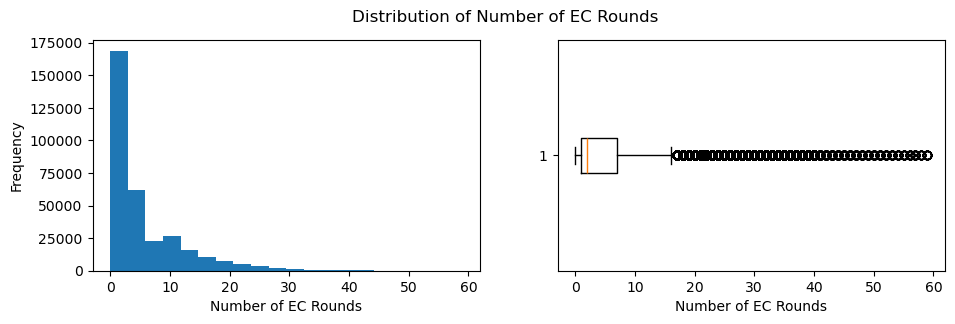

In [31]:
print(df["N_EC_rounds"].describe())
plt.figure(figsize=(11, 3))
plt.subplot(1, 2, 1)
plt.hist(df["N_EC_rounds"], bins=20)
plt.xlabel("Number of EC Rounds")
plt.ylabel("Frequency")
plt.subplot(1, 2, 2)
plt.boxplot(df["N_EC_rounds"], vert=False)
plt.xlabel("Number of EC Rounds")
plt.suptitle("Distribution of Number of EC Rounds")
plt.show()

<Axes: >

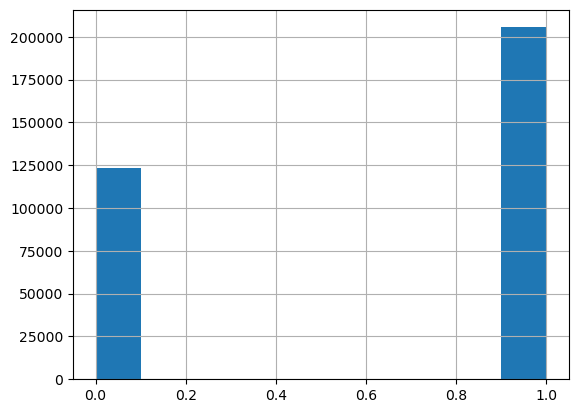

In [33]:
def categorize_n_ec_rounds(n):
    if n < 5:
        return 1
    return 0


df["N_EC_rounds_cat"] = df["N_EC_rounds"].apply(categorize_n_ec_rounds)
df["N_EC_rounds_cat"].hist()

In [38]:
def create_features(df, features, lag, window):
    df = df.copy()
    created_features = []

    for feature in features:
        for l in lag:
            df[f"{feature}_lag_{l}"] = df.groupby("block_id")[feature].shift(l)
            created_features.append(f"{feature}_lag_{l}")
        for w in window:
            df[f"{feature}_roll_mean_{w}"] = (
                df.groupby("block_id")[feature].shift(1).rolling(window=w).mean()
            )
            created_features.append(f"{feature}_roll_mean_{w}")
            df[f"{feature}_roll_std_{w}"] = (
                df.groupby("block_id")[feature].shift(1).rolling(window=w).std()
            )
            created_features.append(f"{feature}_roll_std_{w}")

    df = df.bfill().ffill()
    return df, created_features

In [74]:
features_to_create = phys_features + phys_gt_features + ["E_mu_Z_est", "R", "s", "p"]
df_featured, created_features = create_features(
    df, features_to_create, lag=[2, 5, 10, 20], window=[5, 10]
)
print("Созданные признаки:", created_features)

Созданные признаки: ['bayesImVoltage_lag_2', 'bayesImVoltage_lag_5', 'bayesImVoltage_lag_10', 'bayesImVoltage_lag_20', 'bayesImVoltage_roll_mean_5', 'bayesImVoltage_roll_std_5', 'bayesImVoltage_roll_mean_10', 'bayesImVoltage_roll_std_10', 'opticalPower_lag_2', 'opticalPower_lag_5', 'opticalPower_lag_10', 'opticalPower_lag_20', 'opticalPower_roll_mean_5', 'opticalPower_roll_std_5', 'opticalPower_roll_mean_10', 'opticalPower_roll_std_10', 'polarizerVoltages[0]_lag_2', 'polarizerVoltages[0]_lag_5', 'polarizerVoltages[0]_lag_10', 'polarizerVoltages[0]_lag_20', 'polarizerVoltages[0]_roll_mean_5', 'polarizerVoltages[0]_roll_std_5', 'polarizerVoltages[0]_roll_mean_10', 'polarizerVoltages[0]_roll_std_10', 'polarizerVoltages[1]_lag_2', 'polarizerVoltages[1]_lag_5', 'polarizerVoltages[1]_lag_10', 'polarizerVoltages[1]_lag_20', 'polarizerVoltages[1]_roll_mean_5', 'polarizerVoltages[1]_roll_std_5', 'polarizerVoltages[1]_roll_mean_10', 'polarizerVoltages[1]_roll_std_10', 'polarizerVoltages[2]_lag_2

In [75]:
# Test (Val)
start_idx = df_featured[
    (df_featured["block_id"] == 1489460492) & (df_featured["frame_idx"] == 99)
].index[0]
end_idx = df_featured[
    (df_featured["block_id"] == 1840064900) & (df_featured["frame_idx"] == 101)
].index[0]

test_df = df_featured.loc[start_idx:end_idx].copy()
assert len(test_df) == 2000, "Test (Val) set size is not 2000 rows"

# Train
all_block_ids = df_featured["block_id"].unique()
train_blocks = [bid for bid in all_block_ids if bid not in test_df["block_id"].values]
train_df = df_featured[df_featured["block_id"].isin(train_blocks)]

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")


Train: 326221
Test: 2000


In [76]:
features_in = created_features + phys_features + ["E_mu_Z_est", "R", "s", "p"]
target = "N_EC_rounds_cat"

In [77]:
model_sim = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.05,
    loss_function="Logloss",
    eval_metric="Accuracy",
    verbose=100,
    random_state=42,
    task_type="GPU",
)

model_sim.fit(
    train_df[features_in],
    train_df[target],
    eval_set=(test_df[features_in], test_df[target]),
)

0:	learn: 0.7558772	test: 0.7385000	best: 0.7385000 (0)	total: 13.7ms	remaining: 27.5s
100:	learn: 0.8060732	test: 0.7965000	best: 0.7965000 (100)	total: 1.4s	remaining: 26.3s
200:	learn: 0.8176757	test: 0.8110000	best: 0.8110000 (196)	total: 2.76s	remaining: 24.7s
300:	learn: 0.8236931	test: 0.8155000	best: 0.8160000 (291)	total: 4.13s	remaining: 23.3s
400:	learn: 0.8275188	test: 0.8145000	best: 0.8175000 (340)	total: 5.48s	remaining: 21.9s
500:	learn: 0.8304156	test: 0.8160000	best: 0.8185000 (444)	total: 6.83s	remaining: 20.4s
600:	learn: 0.8325184	test: 0.8155000	best: 0.8185000 (444)	total: 8.17s	remaining: 19s
700:	learn: 0.8341707	test: 0.8180000	best: 0.8190000 (688)	total: 9.64s	remaining: 17.9s
800:	learn: 0.8356114	test: 0.8185000	best: 0.8205000 (777)	total: 11s	remaining: 16.5s
900:	learn: 0.8368652	test: 0.8200000	best: 0.8205000 (777)	total: 12.4s	remaining: 15.1s
1000:	learn: 0.8381373	test: 0.8195000	best: 0.8210000 (936)	total: 13.7s	remaining: 13.7s
1100:	learn: 0.83

In [78]:
train_df["N_EC_rounds_cat_pred"] = model_sim.predict(train_df[features_in]).flatten()

In [79]:
conf_matrix = pd.crosstab(
    train_df["N_EC_rounds"],
    train_df["N_EC_rounds_cat_pred"],
    rownames=["N_EC_rounds (истинное)"],
    colnames=["N_EC_rounds_cat_pred (предсказанное)"],
)

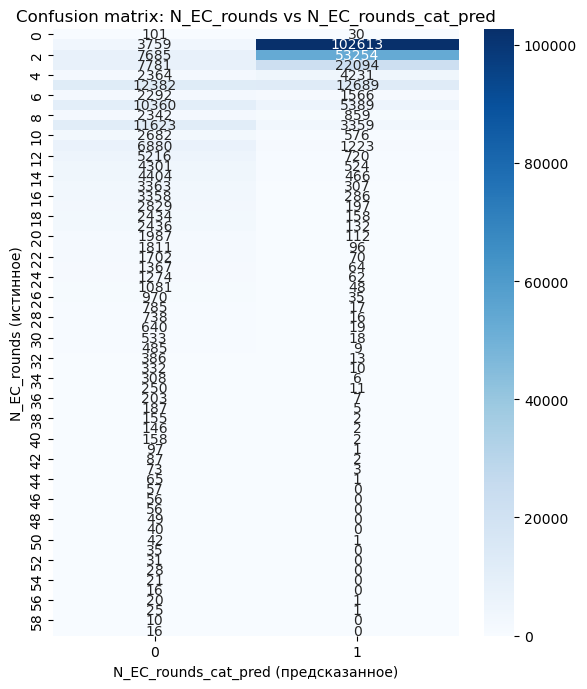

In [80]:
import seaborn as sns

plt.figure(figsize=(6, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix: N_EC_rounds vs N_EC_rounds_cat_pred")
plt.ylabel("N_EC_rounds (истинное)")
plt.xlabel("N_EC_rounds_cat_pred (предсказанное)")
plt.tight_layout()
plt.show()

In [ ]:
def get_submission_reward(df_submit_path, df_path="../../data/frames_errors.csv"):
    df = pd.read_csv(df_path, header=None)
    df.columns = [
        "block_id",
        "frame_idx",
        "E_mu_Z",
        "E_mu_phys_est",
        "E_mu_X",
        "E_nu1_X",
        "E_nu2_X",
        "E_nu1_Z",
        "E_nu2_Z",
        "N_mu_X",
        "M_mu_XX",
        "M_mu_XZ",
        "M_mu_X",
        "N_mu_Z",
        "M_mu_ZZ",
        "M_mu_Z",
        "N_nu1_X",
        "M_nu1_XX",
        "M_nu1_XZ",
        "M_nu1_X",
        "N_nu1_Z",
        "M_nu1_ZZ",
        "M_nu1_Z",
        "N_nu2_X",
        "M_nu2_XX",
        "M_nu2_XZ",
        "M_nu2_X",
        "N_nu2_Z",
        "M_nu2_ZZ",
        "M_nu2_Z",
        "nTot",
        "bayesImVoltage",
        "opticalPower",
        "polarizerVoltages[0]",
        "polarizerVoltages[1]",
        "polarizerVoltages[2]",
        "polarizerVoltages[3]",
        "temp_1",
        "biasVoltage_1",
        "temp_2",
        "biasVoltage_2",
        "synErr",
        "N_EC_rounds",
        "maintenance_flag",
        "estimator_name",
        "f_EC",
        "E_mu_Z_est",
        "R",
        "s",
        "p",
    ]
    submission_df = pd.read_csv(df_submit_path, header=None)
    submission_df.columns = ["E_mu_Z_est", "R", "s", "p"]

    start_idx = df[(df["block_id"] == 1489460492) & (df["frame_idx"] == 99)].index[0]
    end_idx = df[(df["block_id"] == 1840064900) & (df["frame_idx"] == 101)].index[0]
    test_df = df.loc[start_idx:end_idx].copy()
    test_df[["E_mu_Z_est", "R", "s", "p"]] = submission_df[["E_mu_Z_est", "R", "s", "p"]].values

    features_to_create = phys_features + ["E_mu_Z_est", "R", "s", "p"]
    test_df, created_features = create_features(
        test_df, features_to_create, lag=[2, 5, 10, 20], window=[5, 10]
    )

    features_in = created_features + phys_features + ["E_mu_Z_est", "R", "s", "p"]
    reward = model_sim.predict(test_df[features_in]).flatten().sum()
    return reward

In [70]:
get_submission_reward("../catboost_4/submission_3.csv")

0.688

In [71]:
get_submission_reward("submission_1_sim.csv")

1.0

In [72]:
get_submission_reward("../catboost_4/submission_1.csv")

0.6875